In [1]:
##### DNN module

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adagrad, Adam, SGD
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1, l2, l1_l2

#from sklearn.model_selection import train_test_split
#from keras import backend as K
#from keras.applications import ResNet50

Using TensorFlow backend.


In [2]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
##### Common moldule

import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import time
from PIL import Image
from scipy.interpolate import RegularGridInterpolator
import pandas as pd

In [4]:
##### Control Panel

fn_serial   = '021-A-139'
batch_size  = 24
num_classes = 5
epochs      = 200
pic_size    = 240
pool_size   = (2, 2)

In [5]:
##### Selection

Conv2D_size = [(3, 3), (5, 5), (7, 7)]
drop_out    = [0., 0.1]
l2_ratio    = [1e-4, 1e-8]
optimizer   = [Adam(lr=0.01),
               Adam(lr=0.001),
               RMSprop(lr=0.01),
               RMSprop(lr=0.001),
               SGD(lr=0.01, momentum=0.95),
               SGD(lr=0.001, momentum=0.95),
              ]

total_item = len(Conv2D_size) * len(drop_out) * len(l2_ratio) * len(optimizer)
print('Total config:', total_item)

Total config: 72


In [6]:
def create_model(model_name, Conv2D_size, pic_size, l2_ratio, pool_size, drop_out_ratio):
    model = Sequential()
    model.name=model_name
    model.add(Conv2D(32, Conv2D_size, padding='same', input_shape=(pic_size, pic_size, 3), kernel_regularizer=l2(l2_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(128, Conv2D_size, padding='same', kernel_regularizer=l2(l2_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(64, Conv2D_size, padding='same', kernel_regularizer=l2(l2_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Conv2D(32, Conv2D_size, padding='same', kernel_regularizer=l2(l2_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(drop_out_ratio))
    model.add(Flatten())
    model.add(Dense(512, kernel_regularizer=l2(l2_ratio)))
    model.add(Activation('relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(drop_out_ratio))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [7]:
def create_compile(optimizer):
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [8]:
def resampleRGI3d(input_mx, resize_to, dtype='float32'):
    # Ref: 10 3-A-7
    # Ver. 2.1
    # input_mx : numpy array, the original target matrix
    # resize_to: list or tuple with 3 int inside
    a, b, c = np.shape(input_mx)
    p, q, r = resize_to
    z_grid = np.linspace(0, p - 1, a)
    y_grid = np.linspace(0, q - 1, b)
    x_grid = np.linspace(0, r - 1, c)
    RGI = RegularGridInterpolator((z_grid, y_grid, x_grid), input_mx)
    z_grid_t2 = np.arange(p)
    y_grid_t2 = np.arange(q)
    x_grid_t2 = np.arange(r)
    meshgrid_para = np.meshgrid(z_grid_t2, y_grid_t2, x_grid_t2)
    RGI_mesh_mx = RGI((meshgrid_para[0], meshgrid_para[1], meshgrid_para[2]))
    RGI_mx = np.transpose(RGI_mesh_mx, axes=[1, 0, 2]).astype(dtype)
    return RGI_mx

def happy_time(start,stop):
    process_time = round(stop - start)
    ss = process_time % 60
    mm = process_time // 60 % 60
    hh = process_time // 3600
    duration = "Process time == {}s == {}H {}m {}s".format(process_time,hh,mm,ss)
    return duration

In [9]:
path_known = glob.glob('database/image_data/sep_train/*/*')

In [10]:
pic_mean_li = []

for j in range(len(path_known)):
    #serial = os.path.basename(path_known[j])[:-4]
    pic_mean = np.mean(np.asarray(Image.open(path_known[j])))
    pic_mean_li.append(pic_mean)

final_mean = np.sum(pic_mean_li) / len(pic_mean_li)
print(final_mean)

99.55751604919041


In [11]:
def cost_mean(x):
    return (x - final_mean)/255.

In [12]:
path_unknown = glob.glob('database/image_data/test/*')

In [13]:
unknown_dict = {}

for j in range(len(path_unknown)):
    serial = os.path.basename(path_unknown[j])[:-4]
    temp_pic = np.asarray(Image.open(path_unknown[j]))
    temp_pic = cost_mean(resampleRGI3d(temp_pic, (pic_size, pic_size, 3)))
    #temp_shape = np.shape(temp_pic)
    temp_pic = np.expand_dims(temp_pic, axis = 0)
    unknown_dict[serial] = temp_pic

print('Length of unknown dict:', len(list(unknown_dict.keys())))

Length of unknown dict: 2000


In [14]:
##### ImageDataGenerator

augment_generator = ImageDataGenerator(
                                       rotation_range=20,
                                       #rescale=1./255,
                                       #featurewise_center=True,
                                       #featurewise_std_normalization=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True,
                                       #data_format='channels_last',
                                       preprocessing_function = cost_mean,
                                      )

In [15]:
##### Generator for train and validation

train_generator = augment_generator.flow_from_directory('database/image_data/sep_train',
                                                        target_size=(pic_size, pic_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
valid_generator = augment_generator.flow_from_directory('database/image_data/sep_valid',
                                                        target_size=(pic_size, pic_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
train_sample = train_generator.samples
valid_sample = valid_generator.samples

Found 2323 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
data batch shape: (24, 240, 240, 3)
labels batch shape: (24, 5)


Epoch 1/200
96/96 [==============================] - 30s 312ms/step - loss: 1.7421 - accuracy: 0.3797 - val_loss: 1.3594 - val_accuracy: 0.4521
Epoch 2/200
96/96 [==============================] - 31s 323ms/step - loss: 1.2337 - accuracy: 0.5250 - val_loss: 0.8854 - val_accuracy: 0.4454
Epoch 3/200
96/96 [==============================] - 30s 316ms/step - loss: 1.1385 - accuracy: 0.5663 - val_loss: 1.2109 - val_accuracy: 0.4811
Epoch 4/200
96/96 [==============================] - 30s 310ms/step - loss: 1.1034 - accuracy: 0.5807 - val_loss: 1.1307 - val_accuracy: 0.5504
Epoch 5/200
96/96 [==============================] - 29s 305ms/step - loss: 1.0400 - accuracy: 0.6111 - val_loss: 1.3563 - val_accuracy: 0.5546
Epoch 6/200
96/96 [==============================] - 29s 304ms/step - loss: 1.0046 - accuracy: 0.6372 - val_loss: 1.1568 - val_accuracy: 0.5714
Epoch 7/200
96/96 [==============================] - 29s 299ms/step - loss: 0.9792 - accuracy: 0.6446 - val_loss: 0.8795 - val_accuracy:

96/96 [==============================] - 26s 274ms/step - loss: 0.6593 - accuracy: 0.7912 - val_loss: 0.9684 - val_accuracy: 0.7605
Epoch 58/200
96/96 [==============================] - 26s 270ms/step - loss: 0.6732 - accuracy: 0.7925 - val_loss: 0.7886 - val_accuracy: 0.6933
Epoch 59/200
96/96 [==============================] - 26s 272ms/step - loss: 0.6534 - accuracy: 0.8030 - val_loss: 0.5413 - val_accuracy: 0.7584
Epoch 60/200
96/96 [==============================] - 26s 275ms/step - loss: 0.6349 - accuracy: 0.8108 - val_loss: 0.9717 - val_accuracy: 0.6849
Epoch 61/200
96/96 [==============================] - 26s 274ms/step - loss: 0.6406 - accuracy: 0.8025 - val_loss: 0.9425 - val_accuracy: 0.7206
Epoch 62/200
96/96 [==============================] - 26s 273ms/step - loss: 0.5962 - accuracy: 0.8104 - val_loss: 0.7764 - val_accuracy: 0.7605
Epoch 63/200
96/96 [==============================] - 26s 273ms/step - loss: 0.6525 - accuracy: 0.7969 - val_loss: 0.7493 - val_accuracy: 0.708

96/96 [==============================] - 26s 275ms/step - loss: 0.5844 - accuracy: 0.8351 - val_loss: 1.8088 - val_accuracy: 0.7416
Epoch 114/200
96/96 [==============================] - 27s 277ms/step - loss: 0.5998 - accuracy: 0.8312 - val_loss: 0.3140 - val_accuracy: 0.7269
Epoch 115/200
96/96 [==============================] - 26s 274ms/step - loss: 0.6313 - accuracy: 0.8177 - val_loss: 0.7686 - val_accuracy: 0.7479
Epoch 116/200
96/96 [==============================] - 26s 270ms/step - loss: 0.5892 - accuracy: 0.8399 - val_loss: 0.8141 - val_accuracy: 0.7647
Epoch 117/200
96/96 [==============================] - 26s 266ms/step - loss: 0.6077 - accuracy: 0.8230 - val_loss: 0.8641 - val_accuracy: 0.6870
Epoch 118/200
96/96 [==============================] - 26s 269ms/step - loss: 0.5658 - accuracy: 0.8404 - val_loss: 1.2714 - val_accuracy: 0.7290
Epoch 119/200
96/96 [==============================] - 26s 275ms/step - loss: 0.5868 - accuracy: 0.8243 - val_loss: 0.5195 - val_accuracy:

96/96 [==============================] - 26s 274ms/step - loss: 0.5812 - accuracy: 0.8399 - val_loss: 1.1248 - val_accuracy: 0.7437
Epoch 170/200
96/96 [==============================] - 30s 310ms/step - loss: 0.6371 - accuracy: 0.8278 - val_loss: 0.7131 - val_accuracy: 0.7479
Epoch 171/200
96/96 [==============================] - 28s 287ms/step - loss: 0.6136 - accuracy: 0.8282 - val_loss: 0.7387 - val_accuracy: 0.7164
Epoch 172/200
96/96 [==============================] - 29s 298ms/step - loss: 0.6189 - accuracy: 0.8291 - val_loss: 1.7217 - val_accuracy: 0.7395
Epoch 173/200
96/96 [==============================] - 29s 307ms/step - loss: 0.6099 - accuracy: 0.8465 - val_loss: 1.0204 - val_accuracy: 0.7017
Epoch 174/200
96/96 [==============================] - 27s 286ms/step - loss: 0.5722 - accuracy: 0.8412 - val_loss: 0.6360 - val_accuracy: 0.7815
Epoch 175/200
96/96 [==============================] - 27s 286ms/step - loss: 0.5911 - accuracy: 0.8482 - val_loss: 0.8120 - val_accuracy:

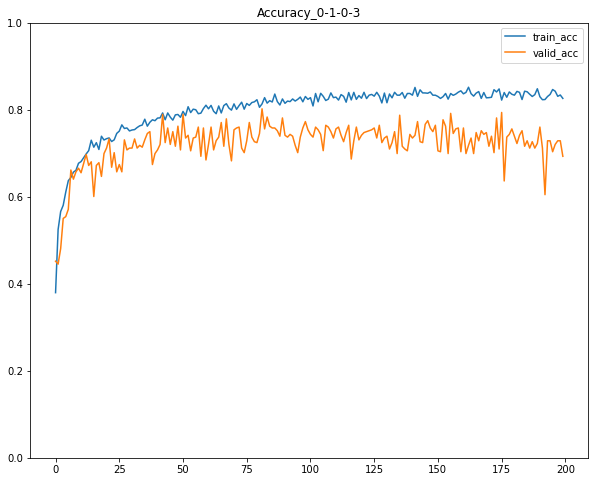

1/72, Model_0-1-0-3 done. Process time == 5441s == 1H 30m 41s


In [16]:
loop_start = time.time()
count = 0

for i in range(0, 1): #len(Conv2D_size)
    for j in range(1, 2): #len(drop_out)
        for k in range(0, 1): #len(l2_ratio)
            for m in range(3, 4): #len(optimizer)
                model_name = f'Model_{Conv2D_size[i]}-{drop_out[j]}-{l2_ratio[k]}-{optimizer[m]}'
                model = create_model(model_name, Conv2D_size[i], pic_size, l2_ratio[k], pool_size, drop_out[j])
                create_compile(optimizer[m])
                history = model.fit(train_generator, epochs=epochs, verbose=1,
                                    steps_per_epoch=int(train_sample/batch_size),
                                    validation_data=valid_generator,
                                    validation_steps=int(valid_sample/batch_size))
                id_li = []
                flower_class = []
                for n in range(len(list(unknown_dict.keys()))):
                    serial = list(unknown_dict.keys())[n]
                    pred = model.predict(unknown_dict[serial])[0]
                    id_li.append(serial)
                    flower_class.append(list(pred).index(max(pred)))
                    pred_result_df = pd.DataFrame(columns=['id', 'flower_class'])
                    pred_result_df['id'] = id_li
                    pred_result_df['flower_class'] = flower_class
                pred_result_df['flower_class'].value_counts().sort_index()
                if not os.path.isdir(f'model/FS_{fn_serial}'):
                    os.mkdir(f'model/FS_{fn_serial}')
                pred_result_df.to_csv(f'model/FS_{fn_serial}/pred_result_FS_{i}-{j}-{k}-{m}.csv', index=False)
                train_acc = model.history.history["accuracy"]
                valid_acc = model.history.history["val_accuracy"]
                np.save(f'model/FS_{fn_serial}/History_{i}-{j}-{k}-{m}.npy', [train_acc, valid_acc])
                plt.figure(figsize=(10,8))
                plt.title(f'Accuracy_{i}-{j}-{k}-{m}')
                plt.ylim([0, 1])
                #plt.xlim([0, 50])
                plt.plot(train_acc, label = 'train_acc')
                plt.plot(valid_acc, label = 'valid_acc')
                plt.legend()
                plt.savefig(f'model/FS_{fn_serial}/Accuracy_{i}-{j}-{k}-{m}.png')
                #plt.clf()
                plt.show()
                count += 1
                print(f'{count}/{total_item}, Model_{i}-{j}-{k}-{m} done. {happy_time(loop_start, time.time())}')

In [17]:
#train_acc